In [56]:
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract

The code for the model can be found [here](https://github.com/jakerobg/cs451blog/blob/main/posts/logistic-regression/logistic.py)


In this blog post, I implemented the popular classification algorithm Logistic Regression with both spicy and vanilla gradient descent. I conducted three experiments. In the first, I found that with no momentum (beta value) vanilla gradient descent was shown to find the optimal weight value for the model as the loss converged at its smallest value. The next experiment expanded on gradient descent by adding momentum and a faster learning rate, which kept the same accuracy, but improved the efficiency of the model's convergence—this was an implementation of "spicy" gradient descent. I then explored the effects of overfitting. I created training and testing datasets with more dimensions (features) than data points, and the resulting accuracy showed a 100% accuracy for training data but a lower accuracy (94%) for test data. Within these experiments, I was able to see the complexities of logistic regression, its advantages of using gradient descent to find an optimal weight and understand/visualize how overfitting can hinder a model.

# Experiments

In order to test out logistic regression and spicy gradient decent, we need code to generate data for our classification.

We will generate points, wherein the number of dimensions controls the number of features and noise represents the difficulty of the problem.

In [57]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.3)

We can also plot this data:

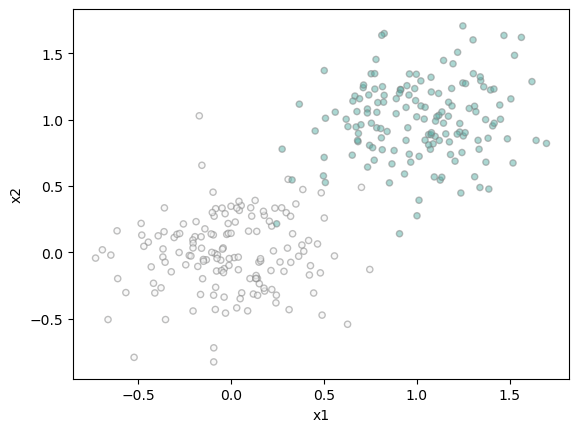

In [58]:
def plot(X, y, ax):
    targets = [0, 1]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], edgecolors = "grey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5)
    ax.set(xlabel = "x1", ylabel = "x2")

figure, ax = plt.subplots(1, 1)


plot(X, y, ax)

Now that we have the points and the algorithm implemented in logistic.py, we need to train our model:

In [59]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(10000):
    # add other stuff to e.g. keep track of the loss over time. 
    opt.step(X, y, alpha = 0.1, beta = 0.9)

# Vanilla Gradient Descent

Using our training loop, we will test and plot out the decision boundary and use a modified training loop, keeping track of the loss to achieve a correct weight vector.

We will keep track of the loss each time so we can graph it and visualize its progression overtime.

We will use 2 dimensions, a small alpha value and beta = 0:

In [60]:
losses = []

LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(10000):
    # add other stuff to e.g. keep track of the loss over time. 
    losses.append(opt.step(X, y, alpha = 0.1, beta = 0.0))

Now we can compute the accuracy by comparing our predictions to the target vector and plot the decision boundary:

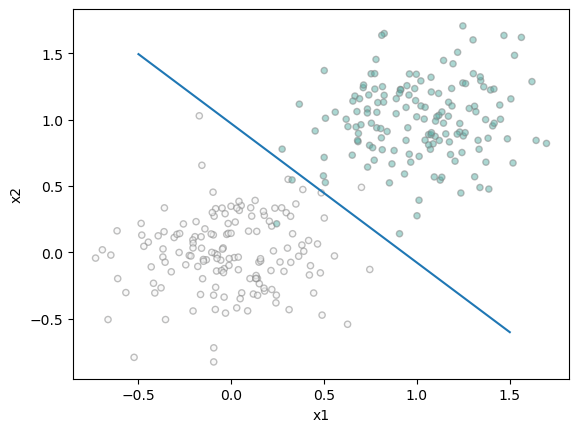

In [61]:
#plot decision region with a draw line function - courtesy of Prof Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

figure, ax = plt.subplots(1, 1)
plot(X, y, ax)
weight =  LR.w
draw_line(weight, -0.5, 1.5, ax)

In [62]:
print("Accuracy: ", torch.mean(1.0 * (LR.predict(X) == y)).item())


Accuracy:  0.9900000095367432


Our accuracy comes out to 0.99 with 10,000 steps in our loop. The decision boundary, given a moderate to low amount of noise seems to create a correct decision boundary between the two classifications.

Since we kept track of the loss, we can plot it's progression overtime:

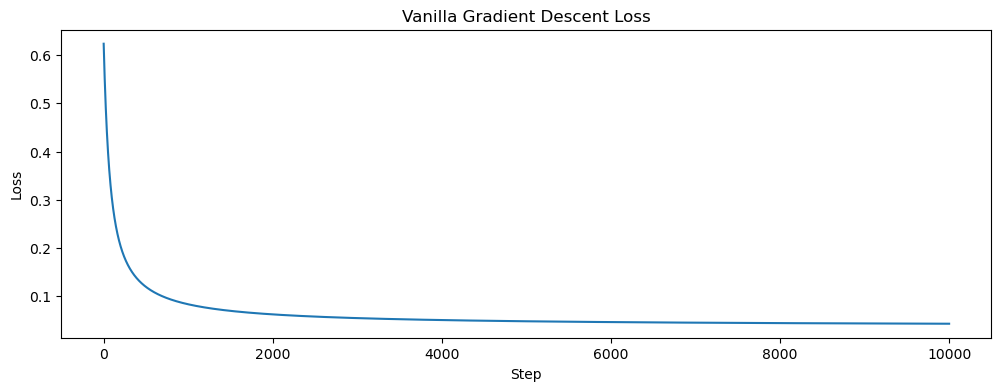

Loss at the final step:  0.04300102964043617


In [63]:
# plotting loss and final loss
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Vanilla Gradient Descent Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

print("Loss at the final step: ", losses[-1].item())


Our loss seems to be correctly decreasing with each step, slowly converging to 0. This shows our weight vector is creating the appropriate decision boundary.

# Experimenting with momentum

Using the same data, by using momentum (changing our beta value to 0.9 for example) can help us converge our weight vector with fewer steps than if beta = 0 (vanilla gradient descent).

Firstly, I want to experiment with an optimal alpha value given a constant beta, then I want to compare the best alpha value with our spicy gradient descent with the vanilla gradient descent in the last experiment. The following code is the same as the last training loop, but has an outer loop that keeps track of the final loss values after 10000 iterations for alpha values ranging from 0.01 to 0.25 in 0.01 increments.

In [71]:
lossesAlpha = []
final_losses_momentum = []

LR_Momentum = LogisticRegression() 
opt_momentum = GradientDescentOptimizer(LR_Momentum)

for j in range(1, 27):
    lossesMomentum = []
    for _ in range(10000):
        # add other stuff to e.g. keep track of the loss over time. 
        lossesAlpha.append(opt_momentum.step(X, y, alpha = float(j) / 100, beta = 0.9))
    final_losses_momentum.append(lossesAlpha[-1])


Now we can visualize the final loss for each alpha value and see which one is optimal with beta = 0.9

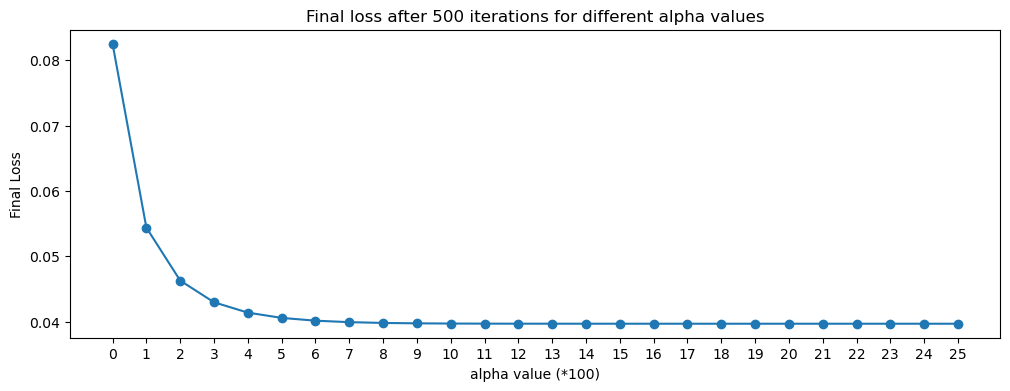

Final loss for alpha = 0.25: 0.0396832711994648


In [72]:
# plotting loss and final loss
plt.figure(figsize=(12, 4))
plt.plot(final_losses_momentum, marker="o")
plt.xticks([x for x in range(0, len(final_losses_momentum))])
plt.title('Final loss after 500 iterations for different alpha values')
plt.xlabel('alpha value (*100)')
plt.ylabel('Final Loss')
plt.show()

print("Final loss for alpha = 0.25:", final_losses_momentum[-1].item())

It appears that after 10000 iterations, our final loss value approaches its lowest for an alpha value of 0.25, without much change after that. In this case, with a beta value of 0.9, we can increase the alpha value to 0.25, which is slightly more efficient than keeping it at 0.1 (or 10 on the graph).

Now we will execute our training loop with 10000 iterations like before, plot the decision region, and find the accuracy

Accuracy with momentum:  0.9900000095367432


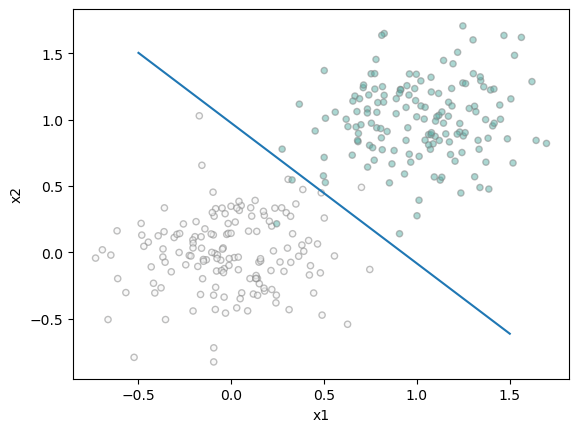

In [73]:
lossesMomentum = []

LR_Momentum = LogisticRegression() 
opt_momentum = GradientDescentOptimizer(LR_Momentum)

for _ in range(10000):
    # add other stuff to e.g. keep track of the loss over time. 
    lossesMomentum.append(opt_momentum.step(X, y, alpha = 0.25, beta = 0.9))


figure, ax = plt.subplots(1, 1)
plot(X, y, ax)
weight =  LR_Momentum.w
draw_line(weight, -0.5, 1.5, ax)

print("Accuracy with momentum: ", torch.mean(1.0 * (LR_Momentum.predict(X) == y)).item())



We retain the same accuracy of 99% after the same amount of iterations with our new alpha and beta values. Now we can plot the change in loss to compare the models with vanilla descent and spicy descent:

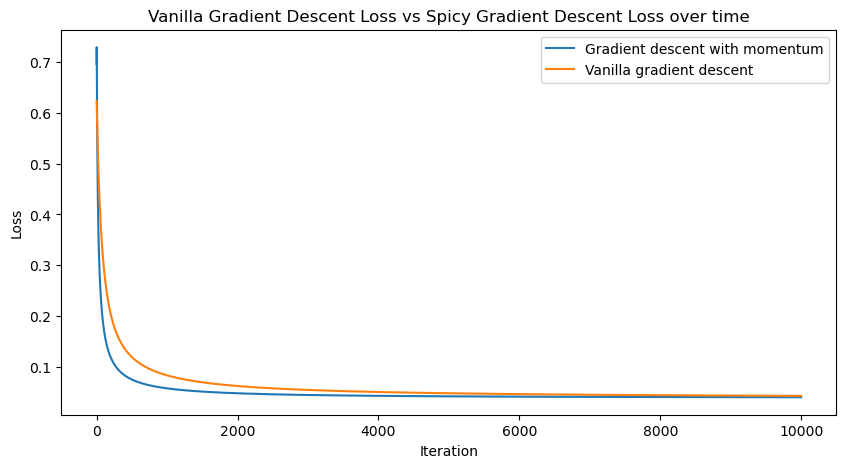

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(lossesMomentum, label = "Gradient descent with momentum")
plt.plot(losses, label="Vanilla gradient descent")
plt.legend()
plt.title('Vanilla Gradient Descent Loss vs Spicy Gradient Descent Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Our plot shows that the spicy gradient descent (descent with momentum or a beta value of 0.9) converges at a faster rate than a model with vanilla gradient descent, therefore this model is faster and more efficient.

# Overfitting

In our last experiment, we will explore overfitting,a nd for that we need data where the number of dimensions (features) is greater than the number of points. This will show how overfitting our model on the testing data will drastically decrease the accuracy even when the training data has high accuracy.

In this case, I will generate a test and train data with 20 points and 100 dimensions. We will also increase the noise to make the problem harder.

In [77]:
X_train, y_train = classification_data(n_points = 20, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 20, noise = 0.5, p_dims = 100)

Now we can use this data to train a new model. This is the same as before, but we want to keep track of the accuracy of both the test and train model over the course of the iterations.

In [78]:
lossesOF = []

LR_OF = LogisticRegression() 
opt_OF = GradientDescentOptimizer(LR_OF)

#
accuracy_test = []
accuracy_train = []

for _ in range(10000):
    # add other stuff to e.g. keep track of the loss over time. 
    lossesOF.append(opt_OF.step(X_train, y_train, alpha = 0.25, beta = 0.9))

    accuracy_test.append(torch.mean(1.0 * (LR_OF.predict(X_test) == y_test)))
    accuracy_train.append(torch.mean(1.0 * (LR_OF.predict(X_train) == y_train)))


print("Final training accuracy:", torch.mean(1.0 * (LR_OF.predict(X_train) == y_train)).item())
print("Final testing accuracy:", torch.mean(1.0 * (LR_OF.predict(X_test) == y_test)).item())



Final training accuracy: 1.0
Final testing accuracy: 0.949999988079071


The final training accuracy comes out to 100%, but because of overfitting, we are given the testing accuracy decreased to 94%.

We can see how much this accuracy changes over our iterations:

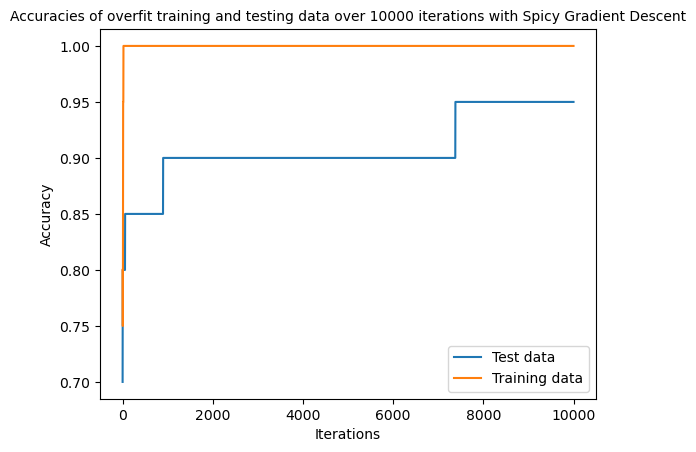

In [79]:
plt.plot(accuracy_test, label="Test data")
plt.plot(accuracy_train, label="Training data")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Iterations")

plt.title("Accuracies of overfit training and testing data over 10000 iterations with Spicy Gradient Descent",fontsize = 10)
plt.show()

With this graph, we can see how the training data is almost immediately 100% accurate, and our testing data flattens out at 94% accuracy, which shows how overfitting with too many features and not enough data for classification can skew the data and accuracy.

# Discussion

Using gradient descent is a good way of calculating the descent of loss for the classification algorithm Logistic Regression. It's process is to recalculate the weight of the model over the iterations in the training loop. While vanilla gradient is a good algorithm for finding the optimal weight, We were able to see the benefits of "momentum" as well as increasing the learning rate to make the model more efficient. Logistic Regression with Spicy Gradient Descent is a great method for classification, but by increasing the amount of dimensions and decreasing the amount of data to work with, we were able to see how this leads to overfitting with a perfect training accuracy but a subsequently lower testing accuracy.

During this blog post, I learned about the implementation of a classification algorithm and how it builds upon basic Linear Models. I was also able to greater understand the benefits of using gradient descent in minimizing loss and finding the optimal weights, as well as the dangers of possibly overfitting data. While accuracy and loss is a good way to examine the accuracy of a model, it might not reveal the whole picture.